# Goals

#### Predict Gender and age in given groups based on the datasets provided 
These datasets come in csv files connected by different identification keys. 

# Understand the data
This is crucial! There are basic explanations on the competitions [website](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data). Here is the data connection diagramm given:
![Data diagramm](data_tree.png)

We also already now that the company names are provided in chinese, which is not particularly helpful. Then, we see that the apps already are categorised, which is handy. However, doubt is present that the variable can be used out-of-the box.

In [1]:
# Set input dir
import sys
tmp = %pwd
files_dir = tmp + "/files" 

In [2]:
# We can have a look what's in the files directory
%ls files/

app_events.csv  gender_age_test.csv   phone_brand_device_model.csv
app_labels.csv  gender_age_train.csv  sample_submission.csv
events.csv      label_categories.csv


In [3]:
# Now import some data and look what we've got 
import pandas as pd
import IPython as ip

ga_test = pd.read_csv(files_dir+"/gender_age_test.csv")
ga_train = pd.read_csv(files_dir+"/gender_age_train.csv")

In [33]:
ip.display.display(ga_test.head(5),ga_test.describe())
# simple device ids. to predict gender and age, we need to combine the devide ids with our features finally used to predict the category

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


,device_id
count,1.120710e+05
mean,-2.367461e+16
std,5.331855e+18
min,-9.223322e+18
25%,-4.661036e+18
50%,-3.107321e+16
75%,4.581985e+18
max,9.223069e+18


#### In total we have 112,071 devices to predict

In [35]:
ip.display.display(ga_train.head(5), ga_train.describe())

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


,device_id,age
count,7.464500e+04,74645.000000
mean,-7.491354e+14,31.410342
std,5.327150e+18,9.868735
min,-9.223067e+18,1.000000
25%,-4.617367e+18,25.000000
50%,-1.841362e+16,29.000000
75%,4.636656e+18,36.000000
max,9.222849e+18,96.000000


#### Unfortunately we have less data to train on, 'only' 74,645 devices. 
We have a rich data structure to explore, I guess we'll end up with k-folding.

In [5]:
g = ga_train['gender']

In [7]:
g.value_counts()

M    47904
F    26741
Name: gender, dtype: int64

In [13]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

(-1.0081850964587609, 1.0152298683632917, -1.0128984268823065, 1.0)

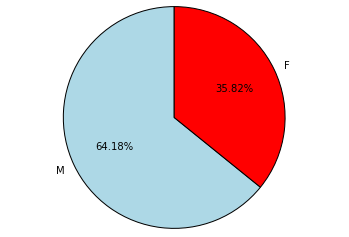

In [9]:
plt.pie(g.value_counts(),colors=['lightblue','red'],labels=g.value_counts().index, autopct='%2.2f%%', startangle=90)
plt.axis('equal')

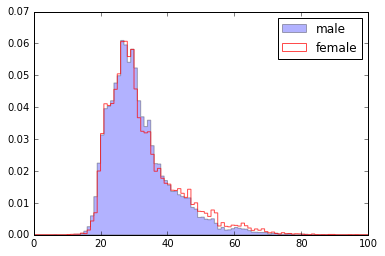

In [12]:
plt.hist(ga_train.age[ga_train.gender=='M'],100,normed=True
         ,color='b',histtype='stepfilled', alpha=0.3
         ,range=(0,100), label='male'); # colon to prevent numeric output prior to plot
plt.hist(ga_train.age[ga_train.gender=='F'],100,normed=True
         ,color='r',histtype='step', alpha=0.7
         ,range=(0,100),label='female');
plt.legend();

Data comes from an SDK, explicit agreement of data use needed. Bias towards male data might be explained by that. Still the age distributions look fairly similar, no need to worry about age biases to this point.
How does the distribution of the training data looks like in the target variable?

In [109]:
ga_train.group[ga_train.gender=="F"].unique()

array(['F24-26', 'F33-42', 'F27-28', 'F43+', 'F23-', 'F29-32'], dtype=object)

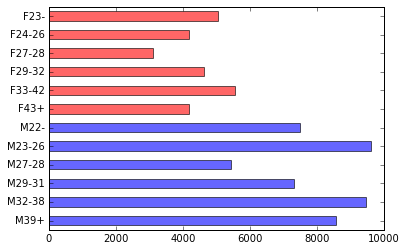

In [46]:
# ok try to color female and male differently
colors = 'r'*len(ga_train.group[ga_train.gender=='F'].unique()) + 'b'*len(ga_train.group[ga_train.gender=='M'].unique())
# this only works if the female and male categories are completely separated. They are not...
# next try, construct color string from indices
a = ga_train.group.value_counts().sort_index(ascending=False)
colors=''
for x in a.index :
    colors+= 'r' if x.startswith('F') else 'b' 

a.plot.barh(color=colors,alpha=0.6); # works fine.

There are different number of customers in each category. When we understand we data a bit better, we can think of applying a deep learning method to predict the categories as follows: a) predict male or female, b) predict age of customer. 
First we need to continue with the data exploration.

In [127]:
# I forgot about the datasets...
%ls files/

app_events.csv  gender_age_test.csv   phone_brand_device_model.csv
app_labels.csv  gender_age_train.csv  sample_submission.csv
events.csv      label_categories.csv


In [53]:
# The next datasets probably easy to merge with the device id are the phone, brand and device information
hardware = pd.read_csv(files_dir+"/phone_brand_device_model.csv")

In [54]:
hardware.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [75]:
hardware.isnull().sum()
len(hardware.device_id)-hardware.device_id.nunique()

529

Ok, there are Chinese company names, which is not really helpful, so we need to translate 'em. Luckily, there are snippets of code in the Kaggle Kernels that do exactly this. I use [this dictionary](https://www.kaggle.com/iuga77/talkingdata-mobile-user-demographics/translate-brand-names-snippet/code).

In [78]:
%run scripts/translate_brands.py

             device_id phone_brand   device_model
0 -8890648629457979026          小米             红米
1  1277779817574759137          小米           MI 2
2  5137427614288105724          三星      Galaxy S4
3  3669464369358936369       SUGAR           时尚手机
4 -5019277647504317457          三星  Galaxy Note 2
             device_id phone_brand   device_model
0 -8890648629457979026      Xiaomi             红米
1  1277779817574759137      Xiaomi           MI 2
2  5137427614288105724     samsung      Galaxy S4
3  3669464369358936369       SUGAR           时尚手机
4 -5019277647504317457     samsung  Galaxy Note 2


In [82]:
hardware = pd.read_csv(files_dir+"/phone_brand_device_model_engl.csv")

In [85]:
hardware.tail(2)

,Unnamed: 0,device_id,phone_brand,device_model
187243,187243,3098391762071677791,vivo,X1
187244,187244,7540390258631417003,vivo,Y22L
